# Recommendation System

**CG(cumulative gain)**  
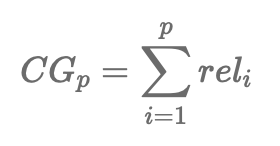
- 상위 p개의 추천 결과들의 관련성(rel, relevance)을 합한 누적값
- rel은 단순히 binary value(관련이 있는지 없는지)이거나 문제에 따라 세분화된 값을 가질 수 있음
- CG는 상위 p개의 추천 결과들을 모두 동일한 비중으로 계산

**DCG(Discounted Cumulative Gain)**  
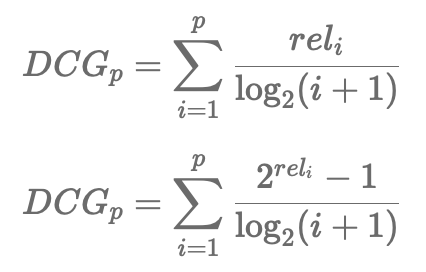
- 기존의 CG에서 랭킹 순서에 따라 점점 비중을 줄여 discounted 된 관련도를 계산하는 방법
- 랭킹 순서에 대한 로그함수를 분모로 두면, 하위권으로 갈수록 rel 대비 작은 DCG 값을 가짐
    - 하위권 결과에 패널티를 주는 방식
- 위의 식(1), 식(2)의 두 가지 형태가 모두 쓰임
    - 식(1)이 standard한 형태이지만, 랭킹의 순서보다 관련성에 더 비중을 주고싶은 경우에는 식(2)를 사용
    - rel이 binary value이면 두 식이 같아짐
    - 특정 순위까지는 discount를 하지 않는 방법 등의 다양한 변형식을 사용하기도 함

**nDCG(normalized Discounted Cumulative Gain)**  
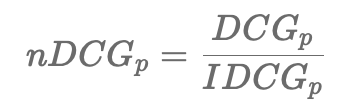
- 기존의 DCG는 랭킹 결과의 길이 p에 따라 값이 많이 변함
    - p가 커질수록 누적합인 DCG는 커짐
- p에 상관없이 일정 스케일의 값을 가지도록 normalize가 필요함
- IDCG는 (rel가 큰 순서대로 재배열한 후 상위 p개를 선택한 rel_opt)에 대해서 DCG를 계산한 결과
    - I for Ideal
    - 선택된 p개 결과로 가질 수 있는 가장 큰 DCG 값
- 평가하려는 추천시스템의 DCG가 IDCG와 같으면 nDCG는 1, rel이 모두 0이면 nDCG는 0
    - nDCG는 항상 0~1 값으로 normalize

In [4]:
import pandas as pd
import numpy as np

In [5]:
product_name_table = pd.read_csv('./Looker Ecommerce BigQuery Dataset/products.csv')

In [6]:
product_name_table = product_name_table.drop(columns=['sku', 'distribution_center_id', 'cost'])
product_name_table = product_name_table.drop_duplicates()
product_name_table['name'] = product_name_table['name'].fillna('')
product_name_table['brand'] = product_name_table['brand'].fillna('')
product_name_table = product_name_table.set_index('id')

In [7]:
product_name_table.shape

(29120, 5)

In [8]:
product_name_table

,category,name,brand,retail_price,department
id,,,,,
13842,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women
13928,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women
14115,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women
14157,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women
14273,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women
...,...,...,...,...,...
5676,Pants & Capris,WHAT GOES AROUND COMES AROUND Women's Colette ...,What Goes Around Comes Around,24.17,Women
6538,Shorts,WHAT GOES AROUND COMES AROUND Women's Mimi Shorts,What Goes Around Comes Around,25.00,Women
6712,Shorts,WHAT GOES AROUND COMES AROUND Women's Fifi Short,What Goes Around Comes Around,25.00,Women


In [9]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [70]:
def ndcg(y_true, y_pred, k=100):
    # DCG at k
    dcg = sum([int(p in y_true) / np.log2(i+2) for i, p in enumerate(y_pred)])

    # IDCG at k
    idcg = sum([1 / np.log2(i+2) for i in range(min(len(y_true), k))])
    
    # NDCG at k
    return dcg / idcg

In [66]:
# 유저별 구매내역 뽑기 (재구매한 유저만 test 존재)
train_dict = train[train.user_id.isin(test.user_id)].groupby('user_id')['product_id'].unique().to_dict()
gt_dict = test.groupby('user_id')['product_id'].unique().to_dict()

튜터님 경험상
- 랜덤: 0.03 정도?
- most popular(그냥 가장 인기 많은 거 모든 유저 똑같이): 0.2 정도?
- 아프리오리 포함한 ML 알고리즘 들어가면: 0.25~0.3 정도
- 개잘해서 찢어버리면: 0.4

In [87]:
# 1. 랜덤 기반
def random_recommendation(product_name_table, n=10):
    unique_products = product_name_table.index.unique()
    random_products = np.random.choice(unique_products, size=n, replace=False)  # 비복원 -> 중복되면 안되니까!
    return random_products

random_products = random_recommendation(product_name_table, 100)

In [88]:
pop_ndcg = []
for user_id in train_dict.keys():
    pop_ndcg.append(ndcg(gt_dict[user_id], random_products))
np.mean(pop_ndcg)

0.0008110767691039707

In [78]:
# 2. 인기도 기반
def popularity_recommendation(order_product, n=10):
    popular_products = order_product.groupby('product_id')['user_id'].count().sort_values(ascending=False).head(n).index
    return popular_products

popular_products = popularity_recommendation(train, 100)

In [79]:
popular_products

Index([23675.0,  5777.0, 18968.0,  8344.0, 20356.0, 17371.0, 19989.0, 20579.0,
       10355.0, 17156.0, 23195.0, 28026.0, 18039.0, 13581.0, 24428.0, 18653.0,
        2652.0, 20472.0, 18460.0, 24969.0,  3112.0, 24962.0, 21931.0, 19180.0,
       21676.0, 16148.0, 16015.0, 22945.0, 25532.0, 16939.0, 22008.0, 24250.0,
       16580.0,  4261.0, 16986.0, 26373.0, 17382.0, 26459.0, 19024.0, 14288.0,
       22537.0, 29113.0, 27625.0, 17783.0,  7793.0, 28263.0,  7088.0, 28411.0,
       19117.0, 20793.0, 21050.0, 18795.0, 12366.0, 26685.0, 23471.0, 21597.0,
       19858.0, 18938.0, 10686.0,  2726.0, 21048.0,  2719.0, 16979.0, 12328.0,
        7223.0, 20993.0,  3845.0, 23132.0, 17021.0, 23140.0, 16413.0, 26990.0,
       13158.0, 17684.0, 22143.0, 27367.0, 19243.0,  1706.0, 18928.0, 26149.0,
       20417.0, 21904.0, 25495.0, 28692.0, 15708.0, 21707.0,  2129.0, 16584.0,
       17527.0, 25328.0, 27751.0, 21842.0, 18296.0, 16704.0,  8030.0, 18990.0,
       16097.0, 18316.0, 16677.0, 27635.0],
      dt

In [86]:
pop_ndcg = []
for user_id in train_dict.keys():
    pop_ndcg.append(ndcg(gt_dict[user_id], popular_products))
np.mean(pop_ndcg)

0.0007811957962509333

1. 상품 특성 코사인 유사도: attr_similarity_matrix.npy
2. 상품명 코사인 유사도: bow_similarity_matrix.npy
3. 협업 코사인 유사도: collaborative_matrix.npy

- input 구조는 test 상품에 맞춰서!

In [64]:
# 3. 컨텐츠 기반: 코사인 유사도 (상품 특성 + 상품명)
attr_sim_matrix = np.load('./attr_similarity_matrix.npy')
bow_sim_matrix = np.load('./bow_similarity_matrix.npy')
collab_sim_matrix = np.load('./collaborative_matrix.npy')

In [65]:
attr_sim_matrix.shape

(29120, 29120)

In [67]:
len(train_dict)

36077

In [68]:
len(gt_dict)

36077

In [69]:
def sim_recommendation(one_train, sim_matrix, k=100):
    # train_dict에서 유저별로 상품별 추천 상위 100개씩 뽑기
    rec_df = []
    for product_id in one_train:
        idx = np.argwhere(product_name_table.index==product_id)[0][0]

        product_similarities = sim_matrix[idx]
        top_k_similar_products = np.argsort(product_similarities)[-k-1:-1][::-1]
        similar_products_attr = product_name_table.iloc[top_k_similar_products]
        similarity = np.sort(product_similarities)[-k-1:-1][::-1]
        rec_df.append(pd.DataFrame(similarity, index=similar_products_attr.index))
        
    rec_df = pd.concat(rec_df)
    rec_df = rec_df.sort_values(0, ascending=False).reset_index().drop_duplicates(subset='id').iloc[:k] # keep='first' (더 높은 순위)

    return rec_df['id'].to_list()

In [71]:
# y_pred: 유저마다 추천 100개 리스트 뽑기 -> dict 형태로
pred_dict = dict()
for user_id in train_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_dict[user_id], attr_sim_matrix)

In [ ]:
attr_ndcg = []
for user_id in train_dict.keys():
    attr_ndcg.append(ndcg(gt_dict[user_id], pred_dict[user_id]))
    # ndcg_score([gt_dict[user_id]], [pred_dict[user_id]])

In [28]:
np.mean(attr_ndcg)

0.0012797469396562929

In [247]:
## 이탈율이 높은 account_traffic_Source = Search랑 특정 연령대 그룹 성능 비교해보기!
#train[train.account_traffic_source=='Search'].user_id.unique()

# 유저별 구매내역 뽑기 (재구매한 유저만 test 존재)
train_search_dict = train[(train.user_id.isin(test.user_id)) & (train.account_traffic_source=='Search')]\
                                                            .groupby('user_id')['product_id'].unique().to_dict()
gt_search_dict = test[test.account_traffic_source=='Search'].groupby('user_id')['product_id'].unique().to_dict()

In [250]:
# 상품 특성 유사도: 가입 유입 경로 Search
pred_dict = dict()
for user_id in train_search_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_search_dict[user_id], attr_sim_matrix)

attr_ndcg = []
for user_id in train_search_dict.keys():
    attr_ndcg.append(ndcg(gt_search_dict[user_id], pred_dict[user_id]))
np.mean(attr_ndcg)

0.0012849255122157584

In [29]:
# 상품명 유사도
pred_dict = dict()
for user_id in train_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_dict[user_id], bow_sim_matrix)

In [30]:
bow_ndcg = []
for user_id in train_dict.keys():
    bow_ndcg.append(ndcg(gt_dict[user_id], pred_dict[user_id]))
np.mean(bow_ndcg)

0.001187095683532687

In [251]:
# 상품명 유사도: 가입 유입 경로 Search
pred_dict = dict()
for user_id in train_search_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_search_dict[user_id], bow_sim_matrix)

bow_ndcg = []
for user_id in train_search_dict.keys():
    bow_ndcg.append(ndcg(gt_search_dict[user_id], pred_dict[user_id]))
np.mean(bow_ndcg)

0.0012812017457588185

In [31]:
# 협업 추천 (상품 특성 + 상품명)
pred_dict = dict()
for user_id in train_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_dict[user_id], collab_sim_matrix)

collab_ndcg = []
for user_id in train_dict.keys():
    collab_ndcg.append(ndcg(gt_dict[user_id], pred_dict[user_id]))
np.mean(collab_ndcg)

0.0011885176130816617

In [90]:
(0.0011885176130816617 + 0.001187095683532687 + 0.0012797469396562929) / 3

0.001218453412090214

In [252]:
# 협업 추천 (상품 특성 + 상품명): 가입 유입 경로 Search
pred_dict = dict()
for user_id in train_search_dict.keys():
     pred_dict[user_id] = sim_recommendation(train_search_dict[user_id], collab_sim_matrix)

collab_ndcg = []
for user_id in train_search_dict.keys():
    collab_ndcg.append(ndcg(gt_search_dict[user_id], pred_dict[user_id]))
np.mean(collab_ndcg)

0.001249424967236258

- 우리 고객들은 유사한 제품을 구매하지 않는구나~ -> 어찌보면 당연, 비슷한 것 중 마음에 드는 걸 샀을듯!  
- hit rate를 보고 싶지만... 데이터가 클릭 -> 구매로 곧바로 이어짐..ㅜㅜ  
=> 유저가 상품을 둘러보지 않는다...! (문제점으로 다시 돌아왔다)

In [32]:
del collab_sim_matrix, bow_sim_matrix, attr_sim_matrix

- A priori...  
카테고리 구매(클릭)한 유저에게 결과절 카테고리의 인기 상품 추천...!

In [74]:
# 유저별 구매내역 뽑기 (재구매한 유저만 test 존재)
train_dict_cat = train[train.user_id.isin(test.user_id)].groupby('user_id')['category'].unique().to_dict()
gt_dict_cat = test.groupby('user_id')['category'].unique().to_dict()

In [41]:
from mlxtend.frequent_patterns import apriori, association_rules
user_product = pd.read_csv('./user_clicked.csv', index_col=0)

from collections import Counter
user_product = user_product.assign(clicked_brand=user_product['clicked_brand'].apply(lambda x: eval(x)))
user_product = user_product.assign(clicked_department=user_product['clicked_department'].apply(lambda x: eval(x)))
user_product = user_product.assign(clicked_category=user_product['clicked_category'].apply(lambda x: eval(x)))
user_product = user_product.assign(clicked_product=user_product['clicked_product'].apply(lambda x: eval(x)))

In [42]:
# Convert the quantities into 0/1 (0: not in the basket, 1: in the basket)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [43]:
user_clicked_category = pd.DataFrame(user_product['clicked_category'].to_list(), index=user_product.index).fillna(0)
user_clicked_category_sets = user_clicked_category.applymap(encode_units)

frequent_clicked_category_sets = apriori(user_clicked_category_sets, min_support=3.0e-4, use_colnames=True)
rules = association_rules(frequent_clicked_category_sets, metric="lift", min_threshold=0.5)

filtered_rules = rules[(rules['lift'] >= 3.0) & (rules['confidence'] >= 0.05)]

/var/folders/ky/h5cjl7dj2y9cj2mn9cv958kc0000gn/T/ipykernel_49360/2683752308.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_clicked_category_sets = user_clicked_category.applymap(encode_units)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [44]:
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
708,"(Intimates, Outerwear & Coats)",(Blazers & Jackets),0.006994,0.032476,0.000702,0.100372,3.090630,0.000475,1.075471,0.681206
796,"(Blazers & Jackets, Pants & Capris)",(Maternity),0.001924,0.051015,0.000338,0.175676,3.443583,0.000240,1.151227,0.710973
797,"(Blazers & Jackets, Maternity)",(Pants & Capris),0.003146,0.034621,0.000338,0.107438,3.103236,0.000229,1.081582,0.679895
798,"(Pants & Capris, Maternity)",(Blazers & Jackets),0.003276,0.032476,0.000338,0.103175,3.176935,0.000232,1.078832,0.687484
802,"(Blazers & Jackets, Leggings)",(Maternity),0.001833,0.051015,0.000338,0.184397,3.614542,0.000245,1.163538,0.724668
...,...,...,...,...,...,...,...,...,...,...
5710,"(Tops & Tees, Accessories, Underwear)",(Socks),0.001300,0.062443,0.000351,0.270000,4.323935,0.000270,1.284324,0.769730
5711,"(Tops & Tees, Accessories, Socks)",(Underwear),0.001326,0.072233,0.000351,0.264706,3.664623,0.000255,1.261763,0.728086
5718,"(Accessories, Socks)","(Tops & Tees, Underwear)",0.006513,0.009517,0.000351,0.053892,5.662953,0.000289,1.046903,0.828812
5740,"(Sleep & Lounge, Fashion Hoodies & Sweatshirts...",(Socks),0.001612,0.062443,0.000312,0.193548,3.099595,0.000211,1.162571,0.678471


- 지지도(support): 빈발 아이템 집합을 판별에 사용, 조건절(𝐴)이 일어날 확률 
    - 𝐹𝑜𝑟 𝑡ℎ𝑒 𝑟𝑢𝑙𝑒 𝐴 → 𝐵, 𝑠𝑢𝑝𝑝𝑜𝑟𝑡(𝐴) = 𝑃(𝐴)
- 신뢰도(confidence): 아이템 집합 간의 연관성 강도를 측정, 조건절(𝐴)이 주어졌을 때 결과절(𝐵)이 일어날 조건부확률 
    - 𝑐𝑜𝑛𝑓𝑖𝑑𝑒𝑛𝑐𝑒(𝐴→𝐵) = 𝑃(𝐴,𝐵) / 𝑃(𝐴)
- 향상도(lift): 생성된 규칙이 실제 효용가치가 있는지를 판별, 조건절과 결과절이 서로 독립일 때와 비교해 두 사건이 동시에 얼마나 발생하는지 비율 
    - 𝑙𝑖𝑓𝑡(𝐴→𝐵) = 𝑃(𝐴,𝐵) / 𝑃(𝐴)⋅𝑃(𝐵)
    - 향상도 1: 조건절과 결과절은 서로 독립임 -> 규칙 사이에 유의미한 연관성이 없다
    - 향상도 2: 두 사건이 독립이라는 걸 가정했을 때 대비 2배로 긍정적인 연관관계
- **세 지표 모두, 보다 클 경우**에 임의의 규칙1이 규칙2보다 효과적인 규칙이다고 평가할 수 있음
- 레버리지(Leverage): 해당 규칙에서 등장하는 상품들이 얼마나 유의미하게 같이 등장하는지
    - A와 B가 독립적이라고 가정할 때의 결합 확률(joint probability)과 실제 결합 확률의 차이
    - 작을수록 좋음
- 확신도(Conviction): 통계적으로 독립일 때와 비교해 보았을 때 얼마나 규칙이 강력한지
    - ‘A와 B가 독립적이지 않을 경우 A가 B 없이 등장할 확률’과 ‘A가 B 없이 등장한 실제 확률’를 비교
    - 일반적인 신뢰도(1개 상품만을 대상으로 구하는 방식의 신뢰도)와는 달리, P(A)와 P(B)를 모두 사용
    - 완전히 독립적인 상품들을 비교할 때는 값이 1을 갖게 됨
    - 향상도와는 반대로, 확신도는 방향이 있는 측도
        - A → B 와 B → A가 다름
        - 확신도가 결과절의 상품이 부재한 경우의 정보를 사용하기 때문

In [45]:
from sklearn.preprocessing import minmax_scale
filtered_rules = filtered_rules.assign(score=(minmax_scale(filtered_rules.support) \
                                                       + minmax_scale(filtered_rules.confidence) \
                                                        + minmax_scale(filtered_rules.lift)
                                                        ) / 3)

In [46]:
filtered_rules.sort_values('score', ascending=False).style.background_gradient()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,score
2387,"frozenset({'Sleep & Lounge', 'Underwear'})",frozenset({'Socks'}),0.007462,0.062443,0.001430,0.191638,3.068995,0.000964,1.159823,0.679229,0.475896
5710,"frozenset({'Tops & Tees', 'Accessories', 'Underwear'})",frozenset({'Socks'}),0.001300,0.062443,0.000351,0.270000,4.323935,0.000270,1.284324,0.769730,0.387229
2284,"frozenset({'Suits', 'Jeans'})",frozenset({'Intimates'}),0.001014,0.124431,0.000403,0.397436,3.194021,0.000277,1.453072,0.687612,0.384538
5390,"frozenset({'Jeans', 'Underwear', 'Sleep & Lounge'})",frozenset({'Socks'}),0.001261,0.062443,0.000338,0.268041,4.292566,0.000259,1.280888,0.768008,0.377528
5614,"frozenset({'Tops & Tees', 'Underwear', 'Sleep & Lounge'})",frozenset({'Socks'}),0.001222,0.062443,0.000325,0.265957,4.259195,0.000249,1.277251,0.766150,0.367455
4822,"frozenset({'Intimates', 'Fashion Hoodies & Sweatshirts'})",frozenset({'Socks & Hosiery'}),0.011428,0.038652,0.001326,0.116041,3.002233,0.000884,1.087549,0.674624,0.363360
5718,"frozenset({'Accessories', 'Socks'})","frozenset({'Tops & Tees', 'Underwear'})",0.006513,0.009517,0.000351,0.053892,5.662953,0.000289,1.046903,0.828812,0.345795
5388,"frozenset({'Jeans', 'Socks', 'Sleep & Lounge'})",frozenset({'Underwear'}),0.001196,0.072233,0.000338,0.282609,3.912472,0.000252,1.293251,0.745299,0.344016
5472,"frozenset({'Swim', 'Jeans', 'Socks'})",frozenset({'Underwear'}),0.001313,0.072233,0.000364,0.277228,3.837977,0.000269,1.283623,0.740418,0.337229
5477,"frozenset({'Swim', 'Socks'})","frozenset({'Jeans', 'Underwear'})",0.006864,0.009556,0.000364,0.053030,5.549639,0.000298,1.045909,0.825475,0.334643


In [49]:
filtered_rules = filtered_rules.sort_values('score', ascending=False)

In [83]:
filtered_rules['antecedents']

2387                 (Sleep & Lounge, Underwear)
5710       (Tops & Tees, Accessories, Underwear)
2284                              (Suits, Jeans)
5390          (Jeans, Underwear, Sleep & Lounge)
5614    (Tops & Tees, Underwear, Sleep & Lounge)
                          ...                   
4205                   (Socks & Hosiery, Shorts)
798                  (Pants & Capris, Maternity)
797               (Blazers & Jackets, Maternity)
5352                       (Leggings, Maternity)
5351                 (Pants & Capris, Maternity)
Name: antecedents, Length: 69, dtype: object

In [51]:
filtered_rules['consequents']

2387                (Socks)
5710                (Socks)
2284            (Intimates)
5390                (Socks)
5614                (Socks)
               ...         
4205       (Pants & Capris)
798     (Blazers & Jackets)
797        (Pants & Capris)
5352       (Pants & Capris)
5351             (Leggings)
Name: consequents, Length: 69, dtype: object

In [71]:
len(train_dict)

36077

In [149]:
antecedents = filtered_rules['antecedents'].map(set)

# 연관 추천 + 인기도 기반
def cat_popularity_recommendation(order_product, cat_list:list, n=10):
    popular_products = order_product[order_product['category'].isin(cat_list)].groupby('product_id')['user_id'].count().sort_values(ascending=False).head(n).index
    return popular_products

def apriori_popularity_rec(one_train_cat):
    if any(antecedents==set(one_train_cat)):
        idx = np.where(antecedents[antecedents==set(one_train_cat)])
        consequents = filtered_rules['consequents'].iloc[idx]
        popular_products = cat_popularity_recommendation(train, list(consequents.values[0]), 100)
        return popular_products
    else:
        return popularity_recommendation(train, 100)

In [150]:
# 연관 추천: A priori + 해당 카테고리 인기도
pred_dict = dict()
for user_id in train_dict.keys():
     pred_dict[user_id] = apriori_popularity_rec(train_dict_cat[user_id])

In [151]:
apriori_ndcg = []
for user_id in train_dict.keys():
    apriori_ndcg.append(ndcg(gt_dict[user_id], pred_dict[user_id]))
np.mean(apriori_ndcg)

0.0007871333081660595

In [258]:
## 이탈율이 높은 account_traffic_Source = Search랑 특정 연령대 그룹 성능 비교해보기!
train_search_dict_cat = train[(train.user_id.isin(test.user_id)) & (train.account_traffic_source=='Search')]\
                                                            .groupby('user_id')['category'].unique().to_dict()

In [260]:
# 연관 추천: A priori + 해당 카테고리 인기도
pred_dict = dict()
for user_id in train_search_dict.keys():
     pred_dict[user_id] = apriori_popularity_rec(train_search_dict_cat[user_id])

apriori_ndcg = []
for user_id in train_search_dict.keys():
    apriori_ndcg.append(ndcg(gt_search_dict[user_id], pred_dict[user_id]))
np.mean(apriori_ndcg)

0.0007986165525772717